# Project: Kernel ridge regression

In lecture 12 I showed how the kernel trick can be used to extend ridge regression to the nonlinear setting. The focus of this assignment is to explore the effect of different kernels and their hyperparameters on the methods capabilities.


1. Simulate one- or two-dimensional regression datasets, i.e. one or two features and a single real valued response (to make things easy to visualise in a 2D or 3D plot). Make sure to make the datasets nonlinear to find settings in which normal linear ridge regression would not work.

2. Check your signal-to-noise ratio to make sure it’s in an “interesting” range (> 1 but not over 10)

3. Use kernel ridge regression with different kernels and investigate which kind of nonlinear shapes can be caught. Always cross-validate over the regularisation parameter lambda and either cross-validate over kernel hyperparameters or analyse their impact on the performance.

4. In addition to visualisation, quantify the results (e.g. by simulating a separate validation set and comparing the final cross-validated models on their test set MSE) and find the best kernel for each of your datasets.

5. Make sure to make your datasets challenging enough so that not all tested kernels perform equally well. Start with a simple sine curve and progress to play with combinations of https://en.wikipedia.org/wiki/Sinc_function (Links to an external site.) and other sin/cos functions. Other nonlinear shapes are of course welcome as well.


In [354]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from sklearn import preprocessing, metrics, kernel_ridge
import seaborn as sns
import pandas as pd

In [355]:
class dataset():  
    """
    Creates a dataset for regression,
    according to: y = X*beta + epsilon.
    add_sparsity function adds sparsity to the beta vector
    """
    
    def __init__(self, n_datapoints, p_coefficients):

        self.X = None
        self.epsilon = None
        self.beta = None
        self.y = None 

        self.n = n_datapoints
        self.p = p_coefficients

        
    def create_data(self, noise_sigma, data_type='sinc',standardise=False):
        self.X = np.random.normal(scale=1, size=(self.n, self.p))
        if standardise == True:
            standard_scaled = preprocessing.StandardScaler()
            self.X = standard_scaled.fit_transform(self.X)
        
        self.epsilon = np.random.normal(scale=noise_sigma, size=(self.n))
        self.beta = np.random.normal(scale=3,size=(self.p,1))
        
        if data_type=='sinc':

            self.y = np.sum(np.sinc(np.dot(self.X,self.beta)), axis=1) + self.epsilon 

            SNR = np.linalg.norm(np.sinc(np.dot(self.X,self.beta)))/np.linalg.norm(self.epsilon)
            
        elif data_type == 'sinus':
            
            self.y = np.sum(np.sin(np.dot(self.X,self.beta)), axis=1) + self.epsilon 
        
            SNR = np.linalg.norm(np.sin(np.dot(self.X,self.beta)))/np.linalg.norm(self.epsilon)
        
        elif data_type == 'cosine':
            self.y = np.sum(np.cos(np.dot(self.X,self.beta)), axis=1) + self.epsilon 
        
            SNR = np.linalg.norm(np.cos(np.dot(self.X,self.beta)))/np.linalg.norm(self.epsilon)
       
        elif data_type == 'X^3':
            
            self.y = np.sum(np.dot(self.X**3, self.beta), axis=1) + self.epsilon
            
            SNR = np.linalg.norm( np.dot(self.X**3, self.beta) ) / np.linalg.norm(self.epsilon)
            
        elif data_type== 'sin+cos':
            self.y = np.sum(np.dot(np.sin(self.X) + np.cos(self.X), self.beta), axis=1) + self.epsilon
            
            SNR = np.linalg.norm( np.dot(np.sin(self.X) + np.cos(self.X), self.beta) ) / np.linalg.norm(self.epsilon)
            
            
        print('SNR = ', SNR )

In [401]:
def kernel_ridge_regression(X_train, y_train, X_test, y_test, alpha, gamma, kernel='linear'):
    
    clf = kernel_ridge.KernelRidge(alpha, kernel, gamma, degree=4)
    clf.fit(X_train, y_train)
    
    y_predict = clf.predict(X_test)
    
    MSE = metrics.mean_squared_error(y_test, y_predict)
    
    return MSE, y_predict

def CV_coefficient(X_train, y_train, X_test, y_test, kernel, alpha, gamma, plot=False):
    alpha_vector = np.linspace(alpha[0],alpha[1],10)
    gamma_vector = np.linspace(gamma[0],gamma[1],10)
    MSE_matrix = []
    
    for g, i in zip(gamma_vector, range(len(gamma_vector))):
        MSE_matrix.append([])
        
        for a in alpha_vector:
            MSE = kernel_ridge_regression(X_train, y_train, X_test, y_test, a, g, kernel)[0]
            MSE_matrix[i].append(MSE)

    MSE_matrix = np.array(MSE_matrix)
    
    optimal_gamma_index, optimal_alpha_index = np.unravel_index(np.argmin(MSE_matrix, axis=None), MSE_matrix.shape)
    optimal_alpha = alpha_vector[optimal_alpha_index]
    optimal_gamma = gamma_vector[optimal_gamma_index]
    
    if plot==True:
        MSE_pd = pd.DataFrame(MSE_matrix, index=np.round(gamma_vector,3), columns=np.round(alpha_vector,3))        
        plt.figure()
        ax = sns.heatmap(MSE_pd)
        plt.title(f'kernel={kernel}' )
        plt.ylabel("gamma")
        plt.xlabel("alpha")
    
    return optimal_alpha, optimal_gamma

def run_script(X_train, X_test, y_train, y_test):
    kernel_list = ['linear', 'polynomial', 'laplacian', 'rbf']

    for kernel in kernel_list:

        optimal_alpha, optimal_gamma = CV_coefficient(X_train, y_train, X_test, y_test, kernel, alpha, gamma)
        MSE, y_predict = kernel_ridge_regression(X_train, y_train, X_test, y_test, optimal_alpha, optimal_gamma, kernel)

        print(kernel, 'alpha:',optimal_alpha, 'gamma:', optimal_gamma, 'MSE:', MSE)

        fig, ax = plt.subplots()
        plt.scatter(X_test, y_test, label='test data')
        plt.scatter(X_test, y_predict, label='predicted data')
        ax.set_title(f'Predicted vs test data, kernel = {kernel}, MSE={MSE} \n alpha={optimal_alpha}, gamma={optimal_gamma}')

SNR =  1.8740817412730035


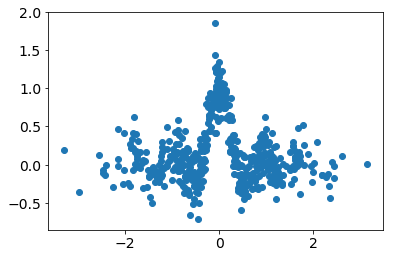

In [402]:
# sinc dataset
data_sinc = dataset(500,1)
data_sinc.create_data(noise_sigma=0.2, data_type='sinc',standardise=False)
X = data_sinc.X
y = data_sinc.y.ravel()
X_train, X_test = X[:400], X[400:]
y_train, y_test = y[:400], y[400:]

gamma = [0.001, 50]
alpha=[0.001, 50]

plt.scatter(X[:,0],y)

linear alpha: 0.001 gamma: 0.001 MSE: 0.19137040258729696
polynomial alpha: 0.001 gamma: 50.0 MSE: 0.14323052073586579
laplacian alpha: 0.001 gamma: 0.001 MSE: 0.03817682325472979
rbf alpha: 5.556444444444445 gamma: 11.111888888888888 MSE: 0.03924467794027926


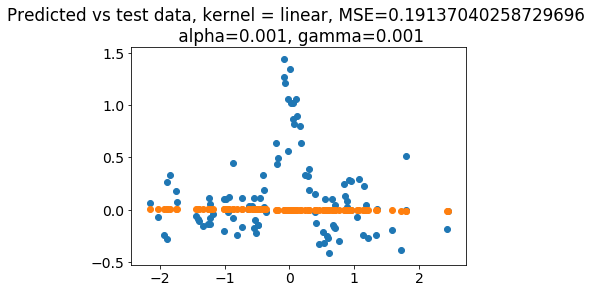

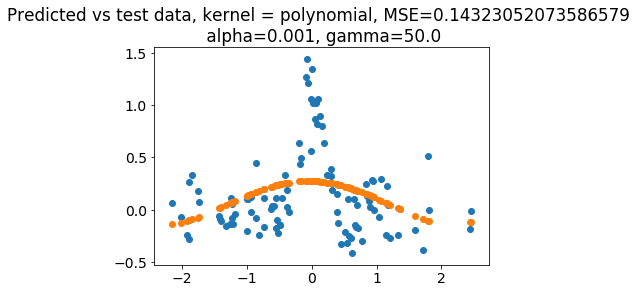

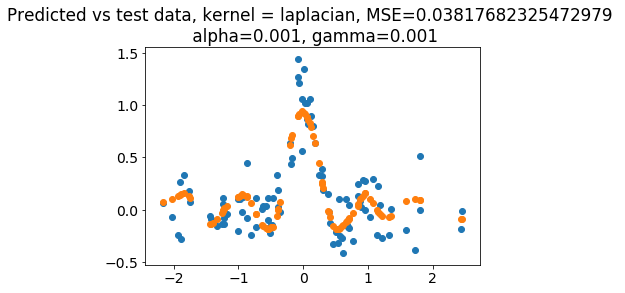

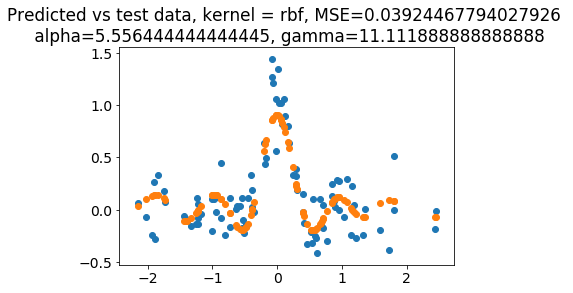

In [403]:
# sinc dataset 
run_script(X_train, X_test, y_train, y_test)

SNR =  5.765775843253683


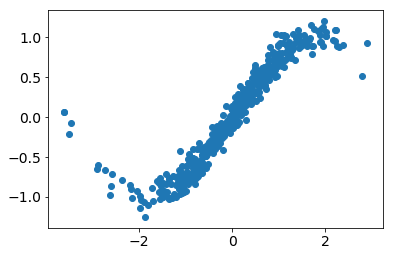

In [404]:
#sinus data
data = dataset(500,1)
data.create_data(0.1, 'sinus',standardise=False)
X = data.X
y = data.y

beta=data.beta

X_train, X_test = X[:400], X[400:]
y_train, y_test = y[:400], y[400:]

gamma = [0.001, 50]
alpha=[0.001, 50]

plt.scatter(X[:,0],y)

linear alpha: 0.001 gamma: 0.001 MSE: 0.06563075185463424
polynomial alpha: 0.001 gamma: 38.889111111111106 MSE: 0.011317435574764969
laplacian alpha: 0.001 gamma: 0.001 MSE: 0.010973054582679704
rbf alpha: 0.001 gamma: 5.556444444444445 MSE: 0.01187626101988961


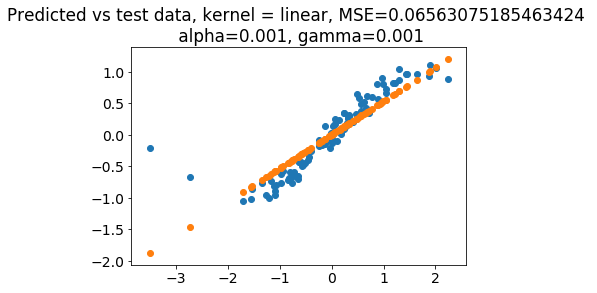

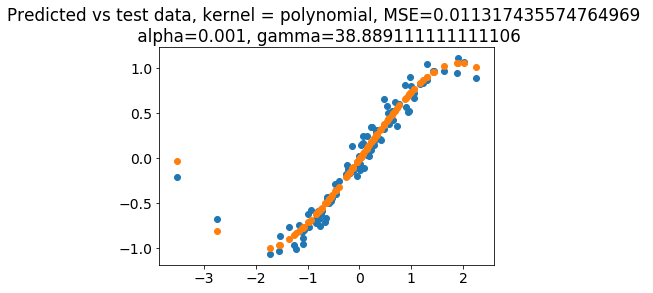

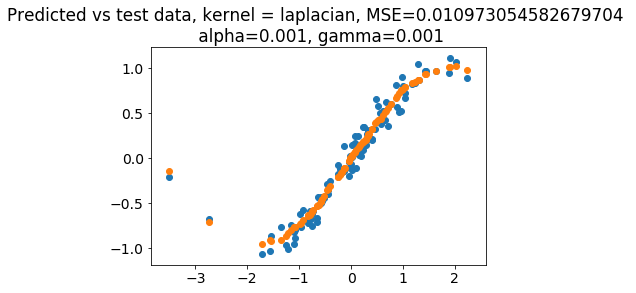

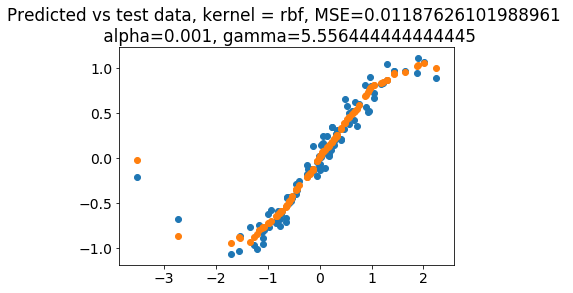

In [405]:
run_script(X_train, X_test, y_train, y_test)

SNR =  7.389550488703632


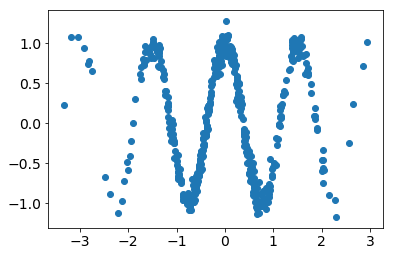

In [406]:
#cosinus data
data = dataset(500,1)
data.create_data(0.1, 'cosine',standardise=False)
X = data.X
y = data.y

beta=data.beta

X_train, X_test = X[:400], X[400:]
y_train, y_test = y[:400], y[400:]

gamma = [0.001, 50]
alpha=[0.001, 50]

plt.scatter(X[:,0],y)

linear alpha: 50.0 gamma: 0.001 MSE: 0.49834300512201707
polynomial alpha: 50.0 gamma: 0.001 MSE: 0.5108146403163031
laplacian alpha: 0.001 gamma: 5.556444444444445 MSE: 0.01816919985119512
rbf alpha: 0.001 gamma: 44.44455555555555 MSE: 0.011233742836250811


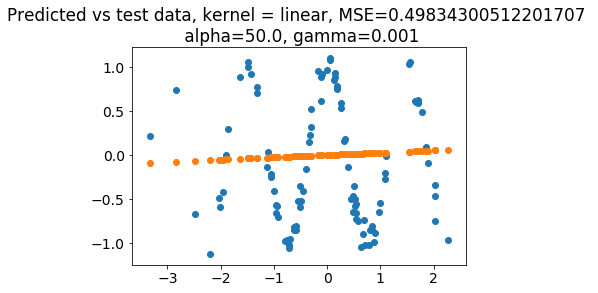

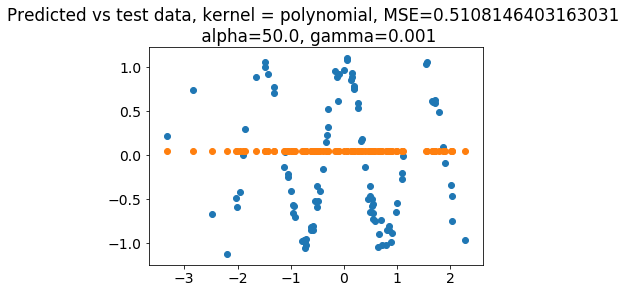

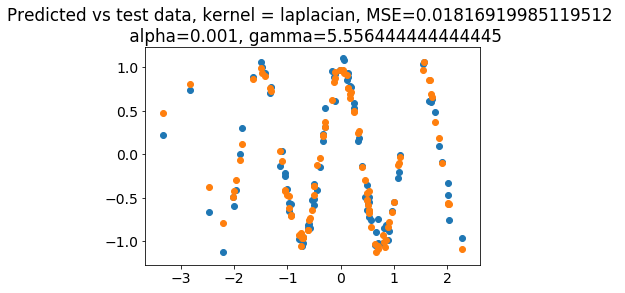

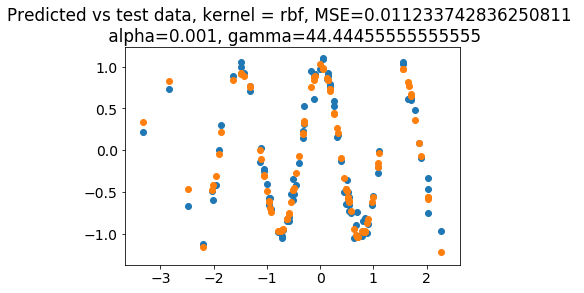

In [407]:
#cosinus data
run_script(X_train, X_test, y_train, y_test)

SNR =  1.9754636057056372


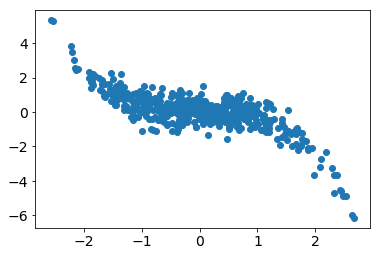

In [408]:
#X^3 data
data = dataset(500,1)
data.create_data(0.5, 'X^3',standardise=False)
X = data.X
y = data.y

beta=data.beta

X_train, X_test = X[:400], X[400:]
y_train, y_test = y[:400], y[400:]

gamma = [0.001, 50]
alpha=[0.001, 50]

plt.scatter(X[:,0],y)

linear alpha: 50.0 gamma: 0.001 MSE: 0.4637104706912059
polynomial alpha: 50.0 gamma: 50.0 MSE: 0.32613865350324434
laplacian alpha: 0.001 gamma: 0.001 MSE: 0.33858757133562434
rbf alpha: 0.001 gamma: 5.556444444444445 MSE: 0.34506836215124237


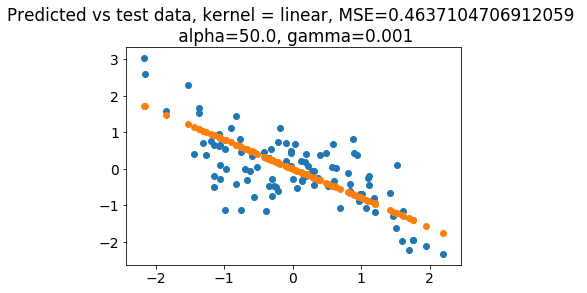

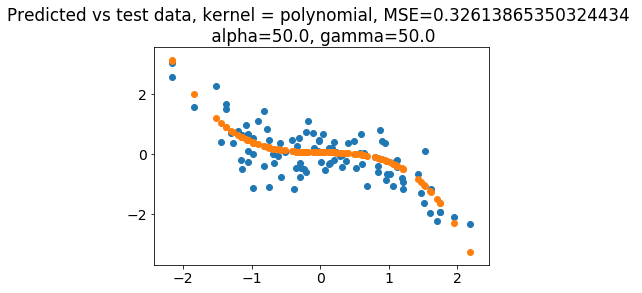

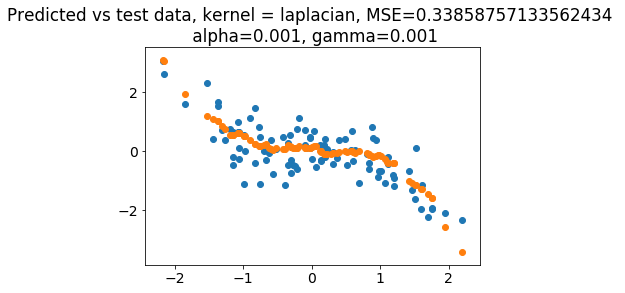

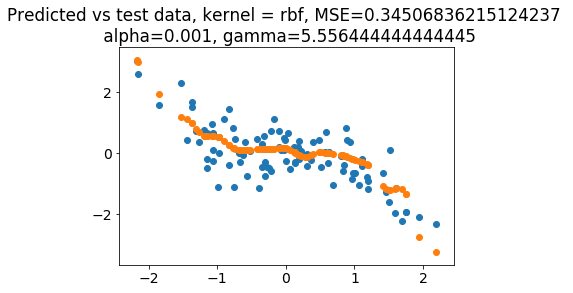

In [409]:
run_script(X_train, X_test, y_train, y_test)

SNR =  4.213886353143315


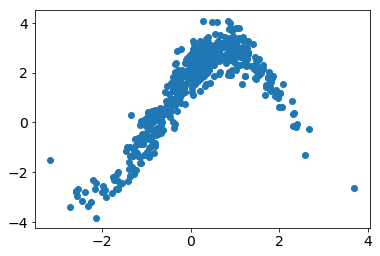

In [410]:
#sin + cos data
data = dataset(500,1)
data.create_data(0.5, 'sin+cos',standardise=False)
X = data.X
y = data.y

beta=data.beta

X_train, X_test = X[:400], X[400:]
y_train, y_test = y[:400], y[400:]

gamma = [0.001, 50]
alpha=[0.001, 50]

plt.scatter(X[:,0],y)

linear alpha: 0.001 gamma: 0.001 MSE: 2.670978227937659
polynomial alpha: 11.111888888888888 gamma: 5.556444444444445 MSE: 0.26400886347927666
laplacian alpha: 0.001 gamma: 0.001 MSE: 0.26629309107454147
rbf alpha: 0.001 gamma: 50.0 MSE: 0.2687671504778331


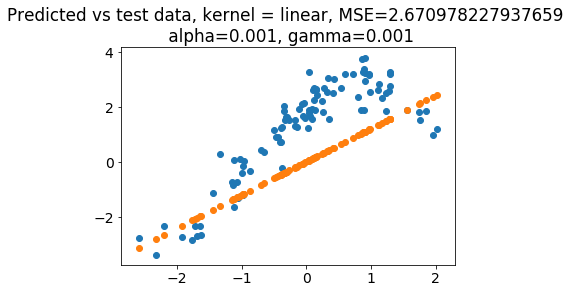

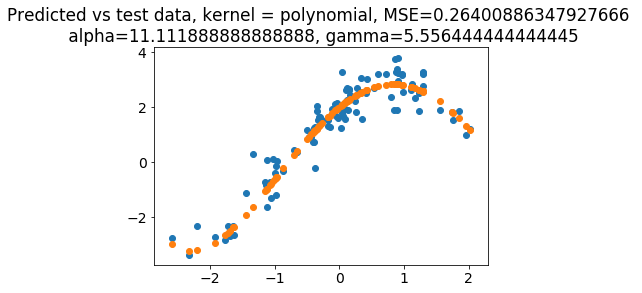

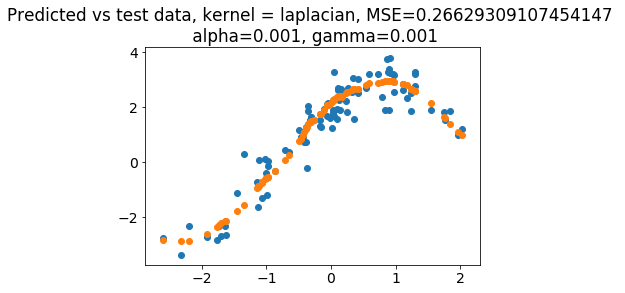

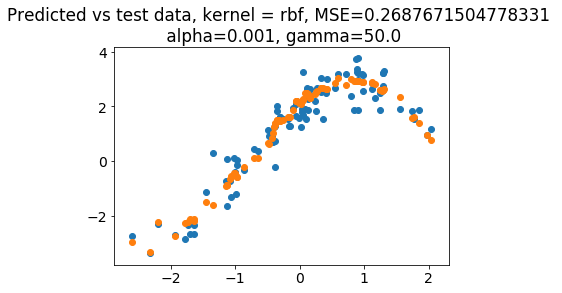

In [411]:
run_script(X_train, X_test, y_train, y_test)